In [297]:
import requests as req
import pandas as pd
import json
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from datetime import date
import pytz

### Getting the data from the API

#### Creating functions to call API and extract data

In [298]:
def api_wrapper(query, start_date, api_key):
    api_str = f'https://content.guardianapis.com/search?q="{query}"&from-date={start_date}&order-by=oldest&api-key={api_key}&type=article&page-size=50&show-fields=body&query-fields=headline'
    response = json.loads(req.get(api_str).content)
    cols = ['id', 'type', 'sectionId', 'sectionName',
            'webPublicationDate', 'webTitle', 'webUrl', 'body']
    df = pd.DataFrame(columns = cols)
    return response, api_str, df

In [299]:
def data_to_df(response, api_str, df):  
    pages = response['response']['pages']
    keys = ['id', 'type', 'sectionId', 'sectionName', 
            'webPublicationDate', 'webTitle', 'webUrl']

    for i in range(1, pages + 1):
        response = json.loads(req.get(api_str + f'&page={i}').content)

        for entry in response['response']['results']:
            write_entry = {k: entry[k] for k in keys}
            write_entry['body'] = entry['fields']['body']
            df = df.append(write_entry, ignore_index=True)
    
    df['webPublicationDate'] = pd.to_datetime(df['webPublicationDate'])
    df['dateTimeLocal'] = df['webPublicationDate'].dt.tz_convert(tz='Europe/Berlin')
    df['body'] = df['body'].str.replace(r'<.*?>', '', regex=True)

    return df

In [373]:
def get_result(df):
    df = df.set_index('webPublicationDate')
    df_grouped = df.groupby(pd.to_datetime((df.index.date))).size().reset_index(name='numberOfArticles')
    df_grouped.set_index('index', inplace=True)

    date_range = pd.date_range(datetime(2018,1,1), datetime.today())
    df_grouped = df_grouped.reindex(index=date_range, fill_value=0)
    df_grouped = df_grouped.reset_index().rename(columns={'index':'date'})
    df_grouped['date'] = df_grouped.date.dt.tz_localize('UTC')

    main_section = df['sectionName'].value_counts().index.tolist()[0]
    # avg_articles = df_grouped['numberOfArticles'].mean()
    # std_dev = df_grouped['numberOfArticles'].std()

    return df_grouped, main_section

In [ ]:
def df_metrics(df, agg_column):
    avg = df[agg_column].mean()
    std = df[agg_column].std()
    return avg, std

def ma_outlier_by_std(df, window_size, num_stds):
    df['MA'] = df.rolling(window=window_size).mean()
    avg, std = df_metrics(df, 'MA')
    spikes_df = df.loc[df.MA > avg + num_stds * std]
    groups = spikes_df['date'].diff().gt(f'{window_size} days').cumsum()
    spike_dfs = [x for _, x in spikes_df.groupby(groups)]

    spike_dfs = [df.loc[(df.date > sdf.iloc[0].date - pd.to_timedelta(f'{window_size} days')) &
                    (result_df.date <= sdf.iloc[-1].date)] for sdf in spike_dfs]
    return spike_dfs

#### Calling functions to extract data, and present an output of article counts per day

In [374]:
query = 'Trudeau'
start_date = '2018-01-01'
api_key = "91f67b2a-520b-4f9f-a4ca-edcb0d610454"

my_json, api_str, df = api_wrapper(query, start_date, api_key)
df = data_to_df(my_json, api_str, df)
result_df, main_section = get_result(df)
result_df

,date,numberOfArticles
0,2018-01-01 00:00:00+00:00,0
1,2018-01-02 00:00:00+00:00,0
2,2018-01-03 00:00:00+00:00,0
3,2018-01-04 00:00:00+00:00,0
4,2018-01-05 00:00:00+00:00,0
...,...,...
1519,2022-02-28 00:00:00+00:00,0
1520,2022-03-01 00:00:00+00:00,0
1521,2022-03-02 00:00:00+00:00,0
1522,2022-03-03 00:00:00+00:00,0


In [358]:
full_df = df

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

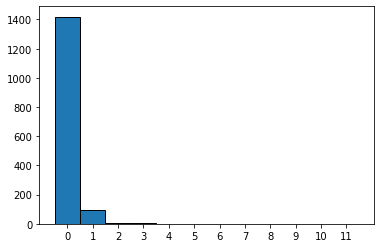

In [304]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.show

<ipython-input-305-2fc9535be686>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<function matplotlib.pyplot.show(close=None, block=None)>

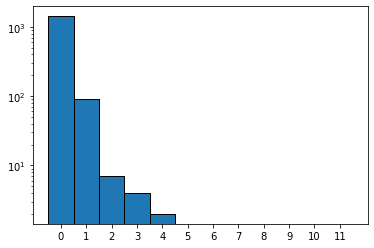

In [305]:
plt.hist(result_df['numberOfArticles'], bins = np.arange(13)-0.5, edgecolor='black')
plt.xticks(range(12))
plt.yscale('log', nonposy='clip')
plt.show

In [306]:
# setting window size and confidence level in terms of 
# stander deviations
window_size = 7
num_stds = 3

# calculation of moving average + mean and std deviation
result_df['MA'] = result_df.rolling(window=window_size).mean()
ma_mean = result_df['MA'].mean()
ma_std = result_df['MA'].std()

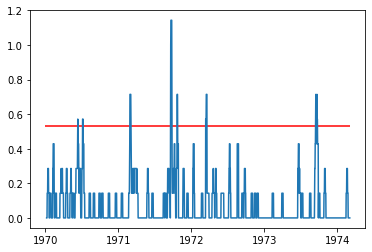

In [382]:
# visualization of the moving average
# and the std line
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots()
ax.plot(result_df.index, result_df.MA)
ax.hlines(y=ma_mean + num_stds * ma_std, xmin=min(result_df.index), xmax=max(result_df.index), color='r')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(years_fmt)

### Topic Modelling

In [413]:
# detecting times of significantly heightened number of articles in grouped representation
dfs = ma_outlier_by_std(result_df, 7, 3)

# creating dataset containing all articles within period of heightened interest
lda_dfs = [full_df.loc[full_df.webPublicationDate.dt.date.isin(df.date.dt.date)] for df in dfs]

def preprocess(dfs):
    import warnings
    warnings.filterwarnings('ignore')
    import stanza
    stanza.download('en')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

    # creating lemmatized representation of text bodies
    for df in dfs:
        df['lemmas'] = df['body'].apply(lemmatize, nlp=nlp)

    # removing stopwords
    from nltk.corpus import stopwords
    df['lemmas'] = df['lemmas'].apply(lambda x: x not in stopwords.words('English'))
    return dfs


def lemmatize(text, nlp):
    doc = nlp(text)
    lemmatized_sen =[]
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.upos in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']:
                lemmatized_sen.append(word.lemma.lower())
    return lemmatized_sen    
    

In [414]:
lda_dfs = preprocess(lda_dfs)
lda_dfs

2022-03-04 23:17:22 INFO: Downloading default packages for language: en (English)...
2022-03-04 23:17:22 INFO: File exists: C:\Users\Felix\stanza_resources\en\default.zip.
2022-03-04 23:17:25 INFO: Finished downloading models and saved to C:\Users\Felix\stanza_resources.
2022-03-04 23:17:25 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-03-04 23:17:25 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2022-03-04 23:17:25 INFO: Use device: cpu
2022-03-04 23:17:25 INFO: Loading: tokenize
2022-03-04 23:17:25 INFO: Loading: pos
2022-03-04 23:17:25 INFO: Loading: lemma
2022-03-04 23:17:25 INFO: Done loading processors!


In [ ]:
from nltk.corpus import stopwords
tokens = lda_df.lemmas.tolist()
tokens = [[word for word in sentence if word not in stopwords.words('English')] for sentence in tokens]


In [412]:
lda_dfs[0]

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,body,dateTimeLocal,lemmas
17,us-news/2018/jun/06/donald-trump-justin-trudea...,article,us-news,US news,2018-06-06 21:01:59+00:00,Trump to Trudeau in testy tariff call: 'Didn't...,https://www.theguardian.com/us-news/2018/jun/0...,He has criticized Canada’s trade polices as “u...,2018-06-06 23:01:59+02:00,"[criticize, canada, trade, police, unfair, dis..."
18,world/2018/jun/10/g7-in-disarray-after-trump-r...,article,world,World news,2018-06-10 02:26:16+00:00,G7 in disarray after Trump rejects communique ...,https://www.theguardian.com/world/2018/jun/10/...,Donald Trump has left the G7 network of global...,2018-06-10 04:26:16+02:00,"[donald, trump, leave, g7, network, global, co..."
19,us-news/2018/jun/10/justin-trudeau-donald-trum...,article,us-news,US news,2018-06-11 12:27:26+00:00,"Trudeau 'stabbed us in back' on trade, says Tr...",https://www.theguardian.com/us-news/2018/jun/1...,Donald’s Trump’s chief economic adviser said t...,2018-06-11 14:27:26+02:00,"[donald, trump, chief, economic, adviser, say,..."
20,us-news/2018/jun/12/trump-trudeau-navarro-apol...,article,us-news,US news,2018-06-12 17:29:39+00:00,Trump's trade adviser apologizes for saying Tr...,https://www.theguardian.com/us-news/2018/jun/1...,White House trade adviser Peter Navarro has ap...,2018-06-12 19:29:39+02:00,"[white, house, trade, adviser, peter, navarro,..."


In [ ]:
# creating data and bigrams
from gensim.models import Phrases
tokens = lda_df.lemmas.tolist()
bigram_model = Phrases(tokens)
tokens = [bigram_model[text] for text in tokens]

In [ ]:
# creating dictionary and corpus
from gensim import corpora
LDA_dict = corpora.Dictionary(tokens)
LDA_dict.filter_extremes(no_below=3)
corpus = [LDA_dict.doc2bow(t) for t in tokens]

In [ ]:
# running LDA
from gensim import models
np.random.seed(69)
num_topics = 5
lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=LDA_dict, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(LDA_dict.keys()))

In [ ]:
lda_model.show_topics(num_words=20)

[(0,
  '0.010*"province" + 0.010*"friday" + 0.009*"way" + 0.008*"border" + 0.008*"year" + 0.007*"club" + 0.007*"close_border" + 0.007*"get" + 0.007*"see" + 0.007*"business" + 0.007*"celebrity" + 0.006*"allow" + 0.006*"bar" + 0.005*"centre" + 0.005*"closure" + 0.005*"think" + 0.005*"as_well" + 0.005*"remember" + 0.005*"place" + 0.005*"stop"'),
 (1,
  '0.016*"airline" + 0.011*"company" + 0.010*"infect" + 0.010*"guardian" + 0.009*"staff" + 0.009*"italy" + 0.008*"down" + 0.008*"australia" + 0.008*"flight" + 0.007*"work" + 0.006*"risk" + 0.006*"worker" + 0.006*"image" + 0.006*"fall" + 0.006*"philippines" + 0.006*"use" + 0.006*"cancel" + 0.005*"begin" + 0.005*"friday" + 0.005*"australian"'),
 (2,
  '0.017*"province" + 0.015*"british" + 0.012*"tuesday" + 0.010*"business" + 0.009*"ontario" + 0.009*"year" + 0.009*"package" + 0.008*"financial" + 0.008*"continue" + 0.007*"citizen" + 0.006*"ford" + 0.006*"care" + 0.006*"overseas" + 0.006*"bring" + 0.006*"market" + 0.006*"chancellor" + 0.006*"alber

TODO:  
- finish topic modelling
  - remove stopwords
  - check what else maybe has to be removed
  - implement it in function to call for all dfs returning useful output
  - clean code
- add visualization of developement over time
- add better viz for confidence interval
- get automation going
- create email / pdf report from findings